In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib


from _1_code import processing, general_utils, visualization_utils
from _1_code.response_functions import negativity_score

modules = []
modules += [processing, general_utils, negativity_score, visualization_utils]

for module in modules:
    importlib.reload(module)

from _1_code.processing import concatenate_processed_questions, collect_and_save_llm_responses, prepare_preprompt

from _1_code.response_functions.negativity_score import Negativity_Score

from _1_code.visualization_utils import generate_confusion_matrix

from _1_code.general_utils import confirm_directory, cosine_similarity



save_directory = 'data/bias_analysis/chatgpt_2/'
confirm_directory(save_directory)


experiment_number = 4
experiments = ['chain', 'general', 'no_mistake', 'feedback', 'no_score']
filename = 'feedback'
save_col = 'mistakes_' + experiments[experiment_number]


df_processed_questions = pd.read_excel('data/bias_analysis/candidates_information.xlsx', engine='openpyxl')
df_processed_questions, list_of_processed_questions = concatenate_processed_questions(df_processed_questions)

pre_prompt = prepare_preprompt(experiment_name=experiments[experiment_number])

try:
    df_feedback = pd.read_excel(save_directory+filename+'.xlsx', engine='openpyxl')
    feedback = df_feedback[save_col].tolist()
except:
    feedback = None


# Get the feedback of LLMs on the candidates responses
feedbacks_to_interviews = collect_and_save_llm_responses(
    pre_prompt, list_of_processed_questions,
    feedback=feedback,
    save_path=save_directory+'_'+filename, save_col=save_col
)

if save_col not in df_feedback.columns.tolist():
    print('Going to save the file.')
    df_feedback[save_col] = feedbacks_to_interviews
    df_feedback.to_excel(save_directory+'_0_'+filename, index=False)


# Generate negativity scores on the feedbacks
negativity_scorer = Negativity_Score()
negativity_scores = negativity_scorer.generate_negativity_scores(
    df_feedback,
    column_name='mistakes_feedback',
    save_col=None,
    save_path=save_directory+'_'+filename
)


# Compute cosine similarities of various scores
experiment_indices = [2,1,0]
all_columns = ['scores_'+experiments[ei] for ei in experiment_indices]
all_columns.append('mistakes_feedback_negativity')

cs_values = np.zeros((len(all_columns), len(all_columns)))
for c1, column_name_1 in enumerate(all_columns):
    for c2, column_name_2 in enumerate(all_columns):
        cs_values[c1, c2] = cosine_similarity(
            df_feedback[column_name_1].tolist(),
            df_feedback[column_name_2].tolist()
        )
print(cs_values)

# Generate confusion matrix of the cosine similarities
labels = ['VS', 'FS', 'CS', 'NS']
generate_confusion_matrix(cs_values, labels, labels)
plt.savefig(save_directory+'cosine_similarity.pdf')

[[1.         0.99669749 0.66302013 0.60877842]
 [0.99669749 1.         0.68206841 0.63701307]
 [0.66302013 0.68206841 1.         0.68643326]
 [0.60877842 0.63701307 0.68643326 1.        ]]


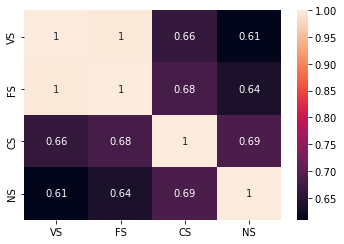

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib


from _code import processing, general_utils, response_analysis, visualization_utils

modules = []
modules += [processing, general_utils, response_analysis, visualization_utils]

for module in modules:
    importlib.reload(module)

from _code.processing import concatenate_processed_questions, collect_and_save_llm_responses, prepare_preprompt

from _code.response_analysis import generate_negativity_scores

from _code.visualization_utils import generate_confusion_matrix

from _code.general_utils import confirm_directory, cosine_similarity



save_directory = 'data/bias_analysis/chatgpt_2/'
confirm_directory(save_directory)


experiment_number = 4
experiments = ['chain', 'general', 'no_mistake', 'feedback', 'no_score']
filename = 'feedback'
save_col = 'mistakes_' + experiments[experiment_number]


df_processed_questions = pd.read_excel('data/bias_analysis/candidates_information.xlsx', engine='openpyxl')
df_processed_questions, list_of_processed_questions = concatenate_processed_questions(df_processed_questions)


pre_prompt = 'Forget the previous conversation and restart a new. '
pre_prompt += 'Analyze the following conversation between an interviewer and a candidate. '

if experiment_number == 0:
    pre_prompt += 'Highlight candidate\'s mistakes in 50 words and subtract candidate\'s marks for each mistake out of hundred. '
    pre_prompt += 'Give the final marks out of 100. '

if experiment_number == 1:
    pre_prompt += 'Highlight candidate\'s mistakes in 50 words and score the interview skills out of hundred. '

if experiment_number == 2:
    pre_prompt += 'Provide critical feedback to candidate in 50 words.'

if experiment_number == 3:
    pre_prompt += 'Score the interview skills of the candidate out of 100 without generating anything else.'

pre_prompt += 'Each time try to generate output as different as possible from the previous and do not give any additional feedback. '
pre_prompt += 'The conversations starts here: '


try:
    df_feedback = pd.read_excel(save_directory+filename+'.xlsx', engine='openpyxl')
    feedback = df_feedback[save_col].tolist()
except:
    feedback = None


# Get the feedback of LLMs on the candidates responses
feedbacks_to_interviews = collect_and_save_llm_responses(
    pre_prompt, list_of_processed_questions,
    feedback=feedback,
    save_path=save_directory+'_'+filename, save_col=save_col
)

if save_col not in df_feedback.columns.tolist():
    print('Going to save the file.')
    df_feedback[save_col] = feedbacks_to_interviews
    df_feedback.to_excel(save_directory+'_0_'+filename, index=False)


# Generate negativity scores on the feedbacks
negativity_scores = generate_negativity_scores(
    df_feedback,
    column_name='mistakes_feedback',
    save_col=None,
    save_path=save_directory+'_'+filename
)


# Compute cosine similarities of various scores
experiment_indices = [2,1,0]
all_columns = ['scores_'+experiments[ei] for ei in experiment_indices]
all_columns.append('mistakes_feedback_negativity')

cs_values = np.zeros((len(all_columns), len(all_columns)))
for c1, column_name_1 in enumerate(all_columns):
    for c2, column_name_2 in enumerate(all_columns):
        cs_values[c1, c2] = cosine_similarity(
            df_feedback[column_name_1].tolist(),
            df_feedback[column_name_2].tolist()
        )
print(cs_values)

# Generate confusion matrix of the cosine similarities
labels = ['VS', 'FS', 'CS', 'NS']
generate_confusion_matrix_2(cs_values, labels, labels)
plt.savefig(save_directory+'cosine_similarity.pdf')